# Multiobjective problem

In [12]:
import matplotlib.pyplot as plt
import random
from deap import tools, base, creator
import numpy as np

def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)


def inversion(ind):
    #invpoint1 = random.randint(0, len(ind) - 2)
    #invpoint2 = random.randint(invpoint1+1, len(ind)-1)
    r1 = random.randint(0, len(ind) - 1)
    r2 = random.randint(0, len(ind) - 1)
    
    invpoint1 , invpoint2 = min(r1,r2), max(r1,r2)
    
    ind[invpoint1:invpoint2+1]=list(reversed(ind[invpoint1:invpoint2+1]))

In [13]:
def evaluateMO(individual, distances, orders, max_capacity=1000):
    
    dist = distances[0, individual[0]]
    cost = max_capacity*dist
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            cost += capacity*distances[i][0]
            dist += distances[i][0]
            capacity = max_capacity
            cost += capacity*distances[0][f]
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            cost += capacity*distances[i][f]
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
    cost+=capacity*distances[0,individual[-1]]
    dist+=distances[0,individual[-1]]
    return (dist,cost/1000)

In [82]:
ind_size=10
def init_SO_EA(ind_size, distances, orders):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(1, ind_size+1), ind_size)
    toolbox.register("individual", tools.initIterate, creator.Individual,
                     toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("evaluateMO", evaluateMO, distances=distances, orders=orders)
    
    toolbox.register("mate",   PMX)
    #toolbox.register("select", tools.selRoulette) 
    toolbox.register("select", tools.selNSGA2) 
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("invert", inversion)
    
    return toolbox

In [83]:
def run_SO_EA(distances, orders, 
              pop_size, 
              elitist_cross, elitist_size, 
              CXPB, MUTPB, INVPB,
              toolbox=None):
    
    if toolbox is None:
        toolbox = init_SO_EA(ind_size, distances, orders)
    
    population = toolbox.population(n=pop_size)
    population = toolbox.select(population, pop_size)
    
    fitnesses = list(map(toolbox.evaluateMO, population))

    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    # Generations     
    g = 0
    # means = []
    mins = []
    # maxs = []
    listfits=[]
    
    while g < 10_000 // pop_size:
        g += 1
        # print(f"----- Generation {g} -----")
        #population.sort(key=lambda x: x.fitness.values[0])
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for mutant in offspring:
            if random.random() < INVPB:
                toolbox.invert(mutant)
                del mutant.fitness.values
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluateMO, invalid_ind))

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        population = toolbox.select(population + offspring, pop_size)
            # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values for ind in population]
        listfits+=[fits]
        #mean = np.mean(fits)
        #std  = np.std(fits)
        # means.append(mean)
        #mins.append(min(fits))
        # maxs.append(max(fits))
    return listfits, population

In [84]:
from TSP_SO import many_runs
# from TSP import plot_route
import numpy as np
import matplotlib.pyplot as plt

In [85]:
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

In [93]:
(listfits,population) = run_SO_EA(distances=dist_central, orders=orders, pop_size=40, 
              elitist_cross=3, elitist_size=32//4, 
              CXPB = 1, MUTPB = 0.2, INVPB=0.3,
              toolbox=None)

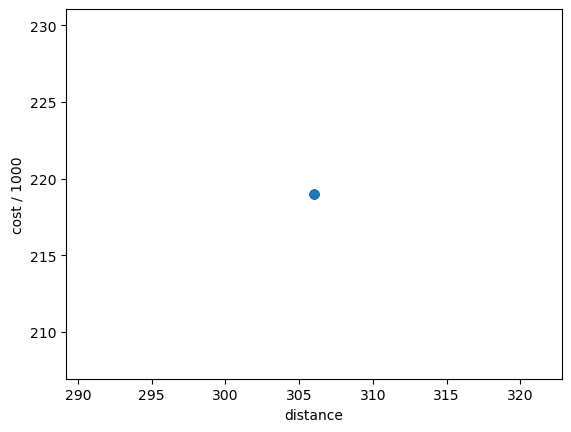

In [94]:
fits=listfits[-1]
fits_x = [x[0] for x in fits]
fits_y = [x[1] for x in fits]
plt.scatter(fits_x,fits_y)
plt.xlabel("distance")
plt.ylabel("cost / 1000")
plt.show()